## Basic Ridge/Lasso

In [1]:
import sys
sys.path.append('../')
# pipeline functions
from qc_pipeline import *
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [ ]:
# working
del sys.modules['qc_pipeline']
from qc_pipeline import *

### Load data and preprocess

Read in normal human colon sample

In [2]:
s1 = sc.read_h5ad('/Users/cody/Dropbox (VU Basic Sciences)/QC_Classifier_Project/datasets/pca_sets/MPX_21B.h5ad')
# see how many "good cells" are manually labeled (1)
s1.obs['bob_filter'].value_counts()

0    6761
1    1369
Name: bob_filter, dtype: int64

In [3]:
%%time
# preprocess data with fcc recipe
recipe_fcc(s1, X_final='arcsinh_norm', mito_names='^MT-')

CPU times: user 8.25 s, sys: 2.2 s, total: 10.4 s
Wall time: 10.4 s


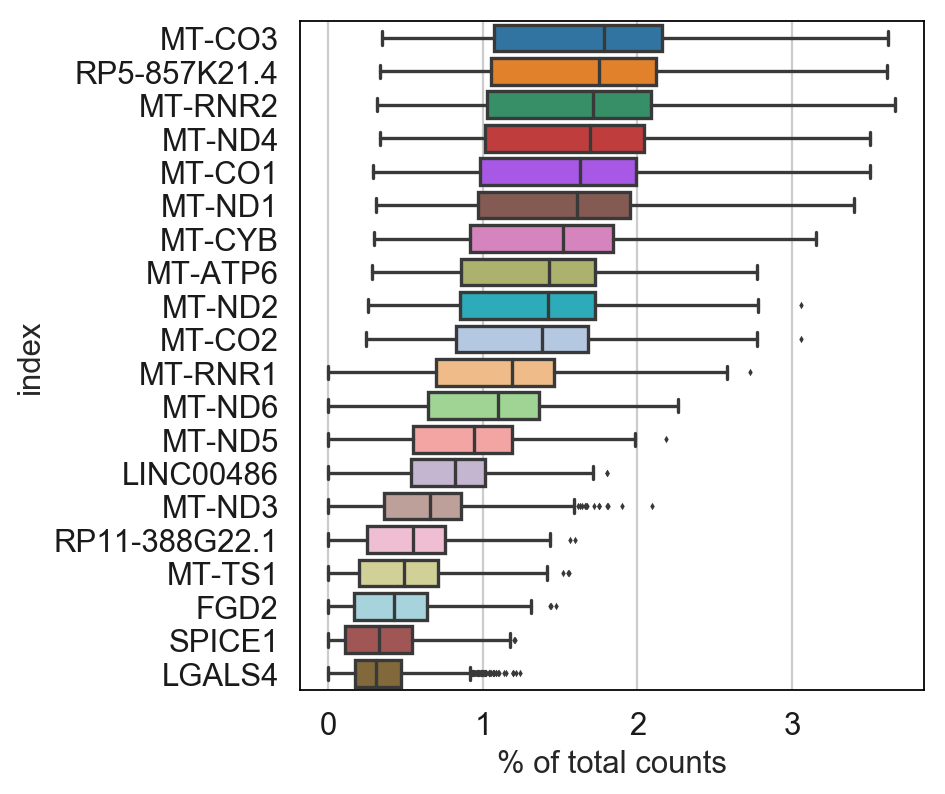

In [4]:
# pct counts in top 50 genes might be useful, as top genes are typically ambient (in empty drops at high frequency)
sc.pl.highest_expr_genes(s1, n_top=20)

In [5]:
s1.var_names[s1.var.ambient]

Index(['MT-CO2', 'MT-RNR1', 'MT-CYB', 'MT-CO3', 'RP5-857K21.4', 'MT-RNR2',
       'MT-ND1', 'MT-ND2', 'MT-CO1', 'LINC00486', 'MT-ND4', 'MT-ND6', 'MT-ND5',
       'MT-ATP6', 'MT-ND3'],
      dtype='object', name='index')

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [6]:
s1_thresh = auto_thresh_obs(s1, method='otsu')

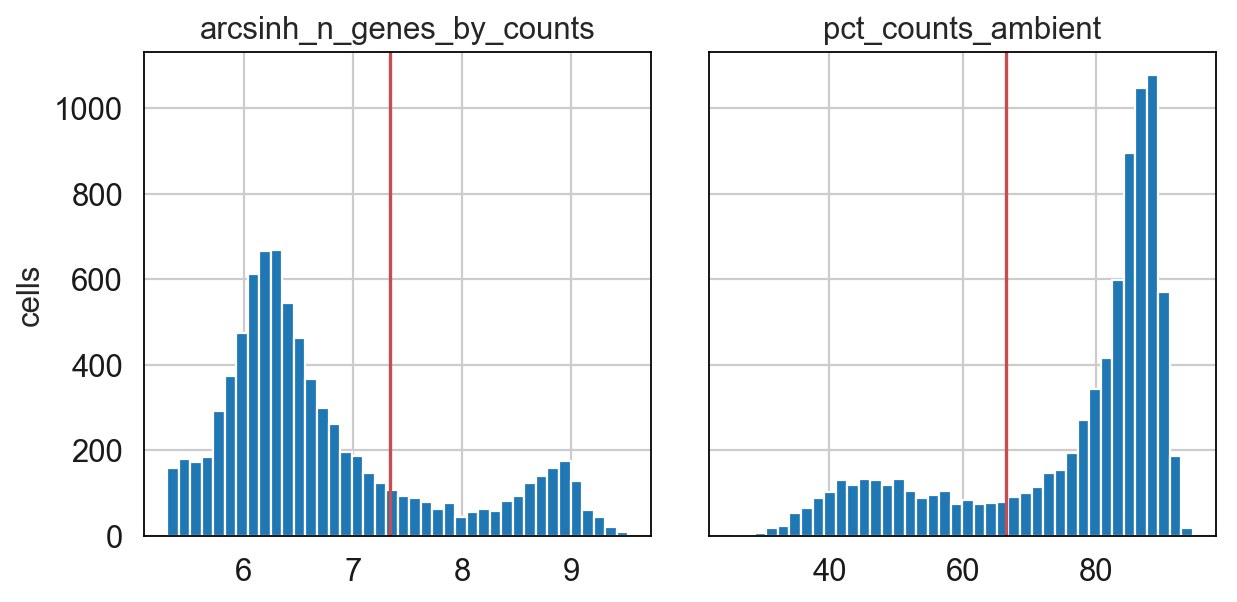

In [7]:
plot_thresh_obs(s1, s1_thresh)

### a couple different ways of visualizing these thresholds vs manual filter...

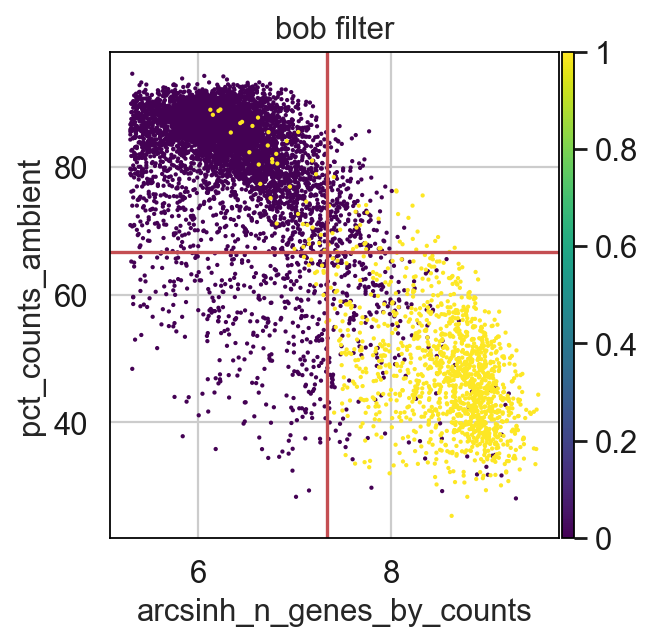

In [8]:
ax = sc.pl.scatter(adata=s1, x='arcsinh_n_genes_by_counts', y='pct_counts_ambient', color='bob_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_ambient'], color='r')
plt.show()

---
### Use combination of the above 5 filters to "hard threshold" our dataset and compare to manual labels

In [9]:
%%time
filter_thresh_obs(s1, 
                  s1_thresh,
                  obs_cols=['arcsinh_n_genes_by_counts','pct_counts_ambient'], 
                  directions=['above','below'],
                  name='thresh_filter'
                 )

CPU times: user 6.07 ms, sys: 1.12 ms, total: 7.19 ms
Wall time: 6.12 ms


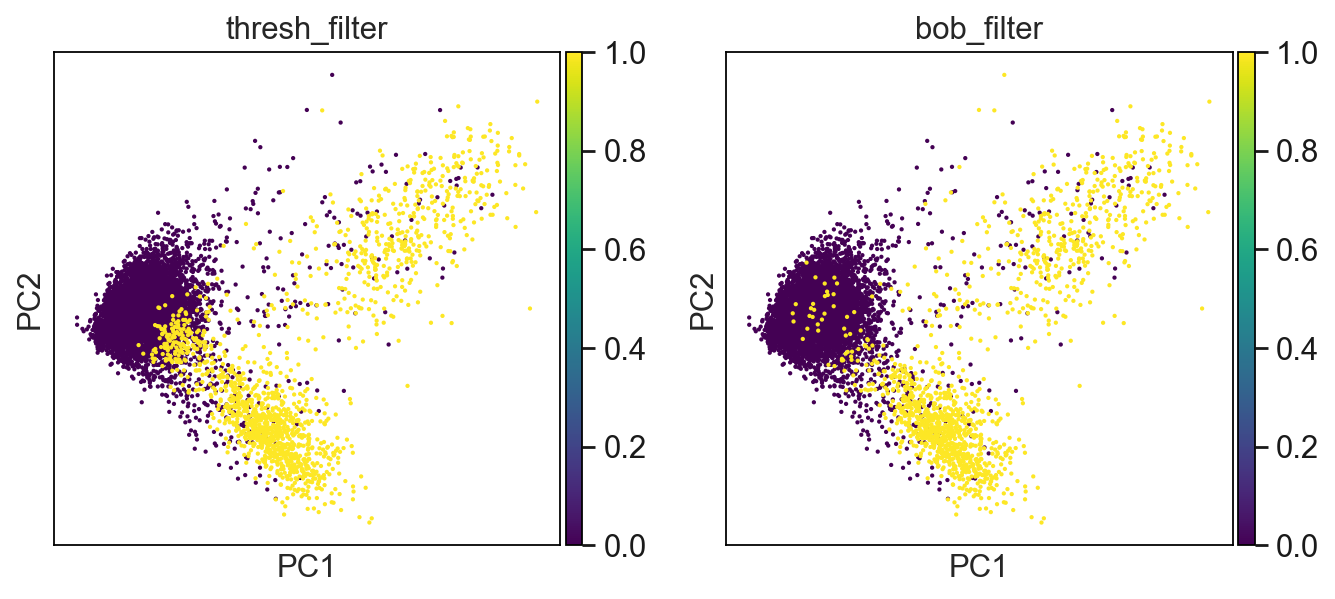

CPU times: user 3.79 s, sys: 734 ms, total: 4.52 s
Wall time: 1.14 s


In [10]:
%%time
# perform 10-component PCA (for training our classifiers later) and look at the two filter labels side-by-side
sc.tl.pca(s1, n_comps=10)
sc.pl.pca(s1, color=['thresh_filter','bob_filter'])

#### Look at set differences with manual label:

In [14]:
from qc_test import set_diff

In [15]:
set_diff(s1, labels=['thresh_filter','bob_filter'])

1507 cells in thresh_filter - 223 unique
1369 cells in bob_filter - 85 unique


---
#### Train Ridge regression model on thresholded labels

In [33]:
# define X and y for classifier training for simplicity
X = s1.X[:,s1.var.highly_variable].copy() # training data is arcsinh-counts of HVGs
y = s1.obs['thresh_filter'].copy(deep=True) # training labels are from .obs df
print(X.shape, y.shape)

(8130, 2003) (8130,)


In [34]:
rc = RidgeClassifierCV(alphas=[100, 200, 300, 400, 500], store_cv_values=True)
rc.fit(X, y)

RidgeClassifierCV(alphas=array([100, 200, 300, 400, 500]), class_weight=None,
                  cv=None, fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=True)

In [35]:
s1.obs['ridge_score'] = rc.decision_function(X)

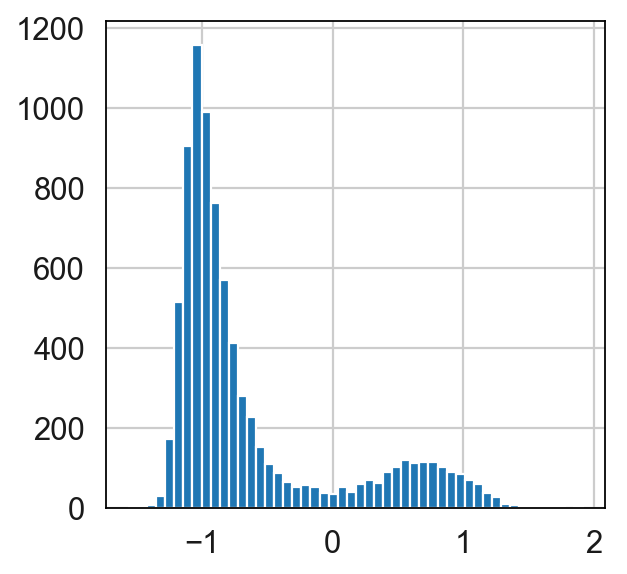

In [36]:
# distribution of scores should be bimodal at 0 and 1
_ = plt.hist(s1.obs['ridge_score'], bins=50)

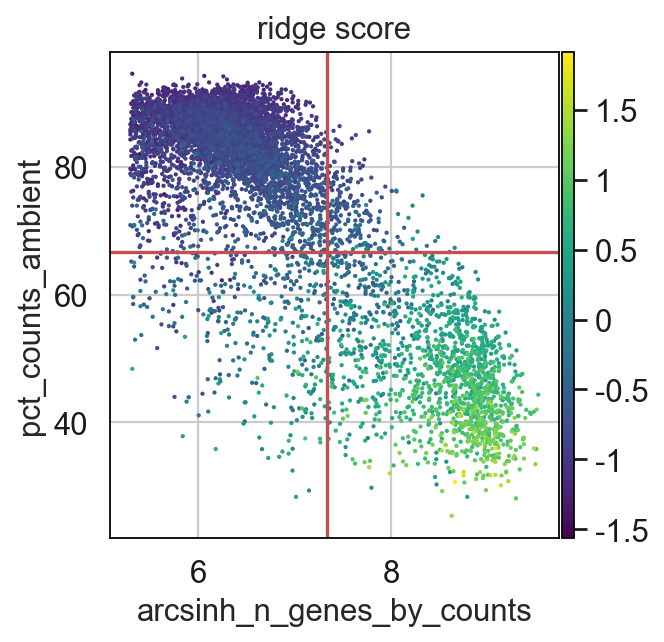

In [37]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='ridge_score', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_ambient'], color='r')
plt.show()

In [38]:
s1.obs['ridge_label'] = rc.predict(X)

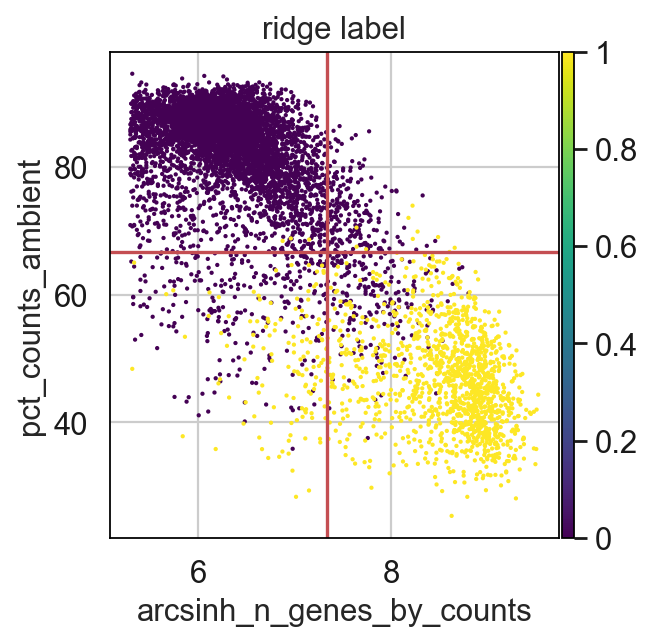

In [39]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='ridge_label', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_ambient'], color='r')
plt.show()

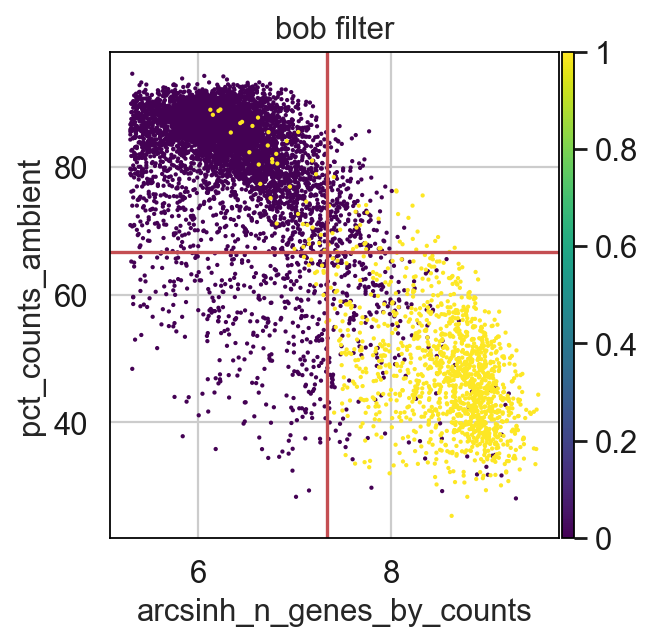

In [40]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='pct_counts_ambient', x='arcsinh_n_genes_by_counts', color='bob_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['pct_counts_ambient'], color='r')
plt.show()

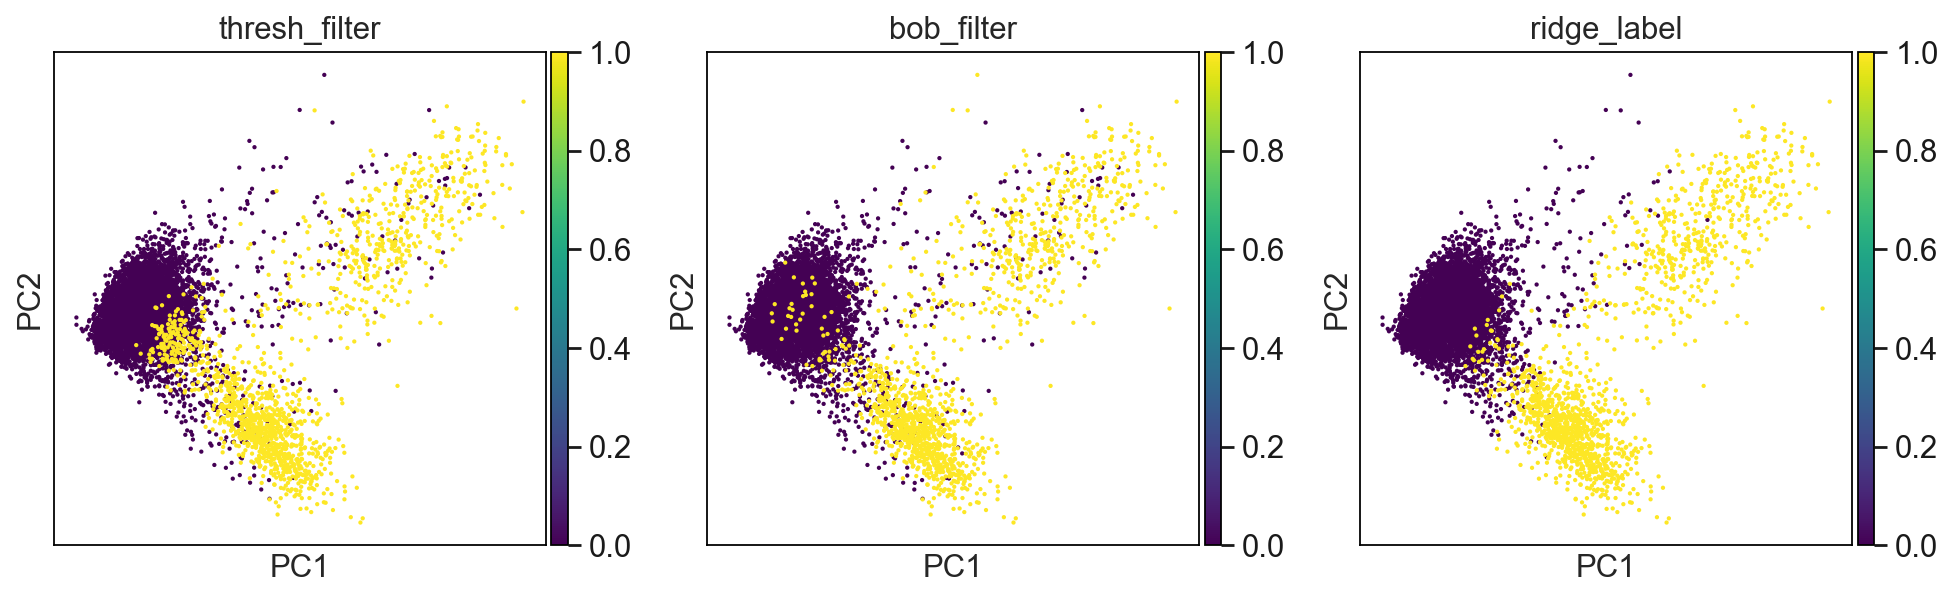

In [41]:
# compare two-step results to threshold filtering and Ken's labels
sc.pl.pca(s1, color=['thresh_filter','bob_filter','ridge_label'])

In [42]:
set_diff(s1, labels=['ridge_label','bob_filter'])

1462 cells in ridge_label - 183 unique
1369 cells in bob_filter - 90 unique


In [56]:
rc.coef_.min()

-0.12380515936423106

In [44]:
rc.intercept_

array([-0.02715644])

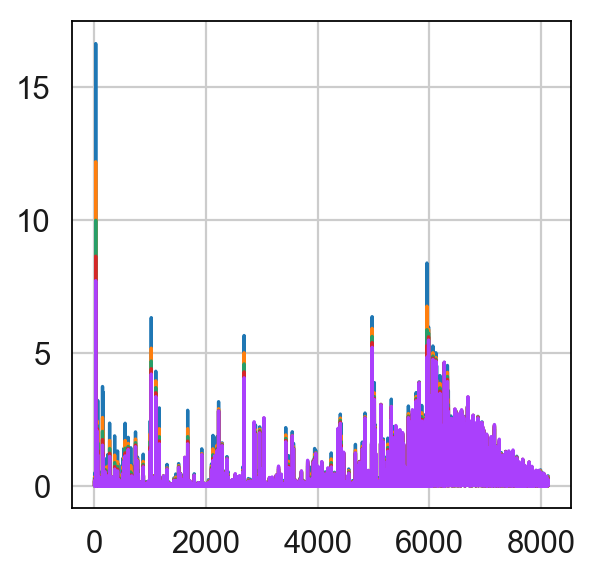

In [54]:
plt.plot(rc.cv_values_.squeeze())

In [57]:
# generate obs column with ken vs twostep for visualization
s1.obs['compare'] = 'same'
s1.obs.loc[(s1.obs['bob_filter']==1) & (s1.obs['ridge_label']==0), 'compare'] = 'manual'
s1.obs.loc[(s1.obs['ridge_label']==1) & (s1.obs['bob_filter']==0), 'compare'] = 'ridge'

In [58]:
# create two new adata objects from ken and twostep filters
s1_ken = s1[s1.obs['bob_filter']==1,:].copy()
s1_ridge = s1[s1.obs['ridge_label']==1,:].copy()

In [59]:
# preprocess ken's dataset
s1_ken.X = s1_ken.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ken, min_cells=1)
recipe_fcc(s1_ken, X_final='arcsinh_norm', mito_names='^MT-')
s1_ken.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ken.obs['n_genes_by_counts'])

... storing 'compare' as categorical


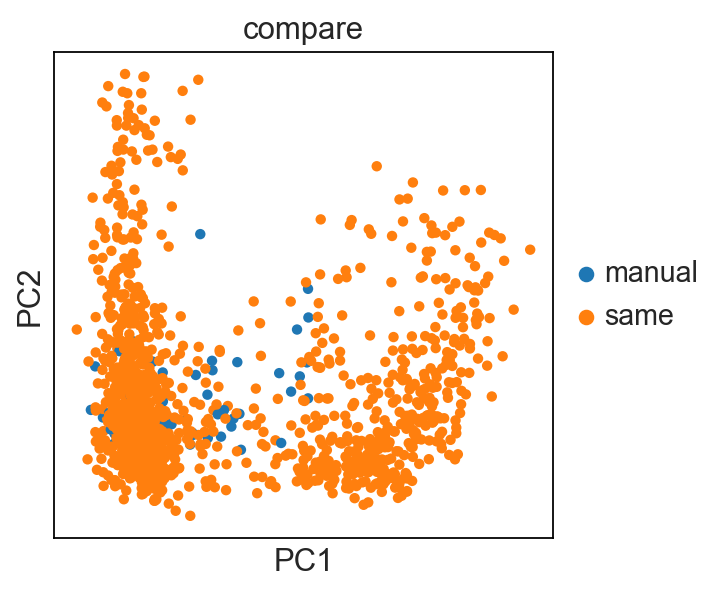

CPU times: user 1.44 s, sys: 269 ms, total: 1.71 s
Wall time: 290 ms


In [60]:
%%time
sc.tl.pca(s1_ken, n_comps=10)
sc.pl.pca(s1_ken, color=['compare'])

In [61]:
sc.pp.neighbors(s1_ken, n_neighbors=int(np.sqrt(s1_ken.n_obs)))
sc.tl.umap(s1_ken)

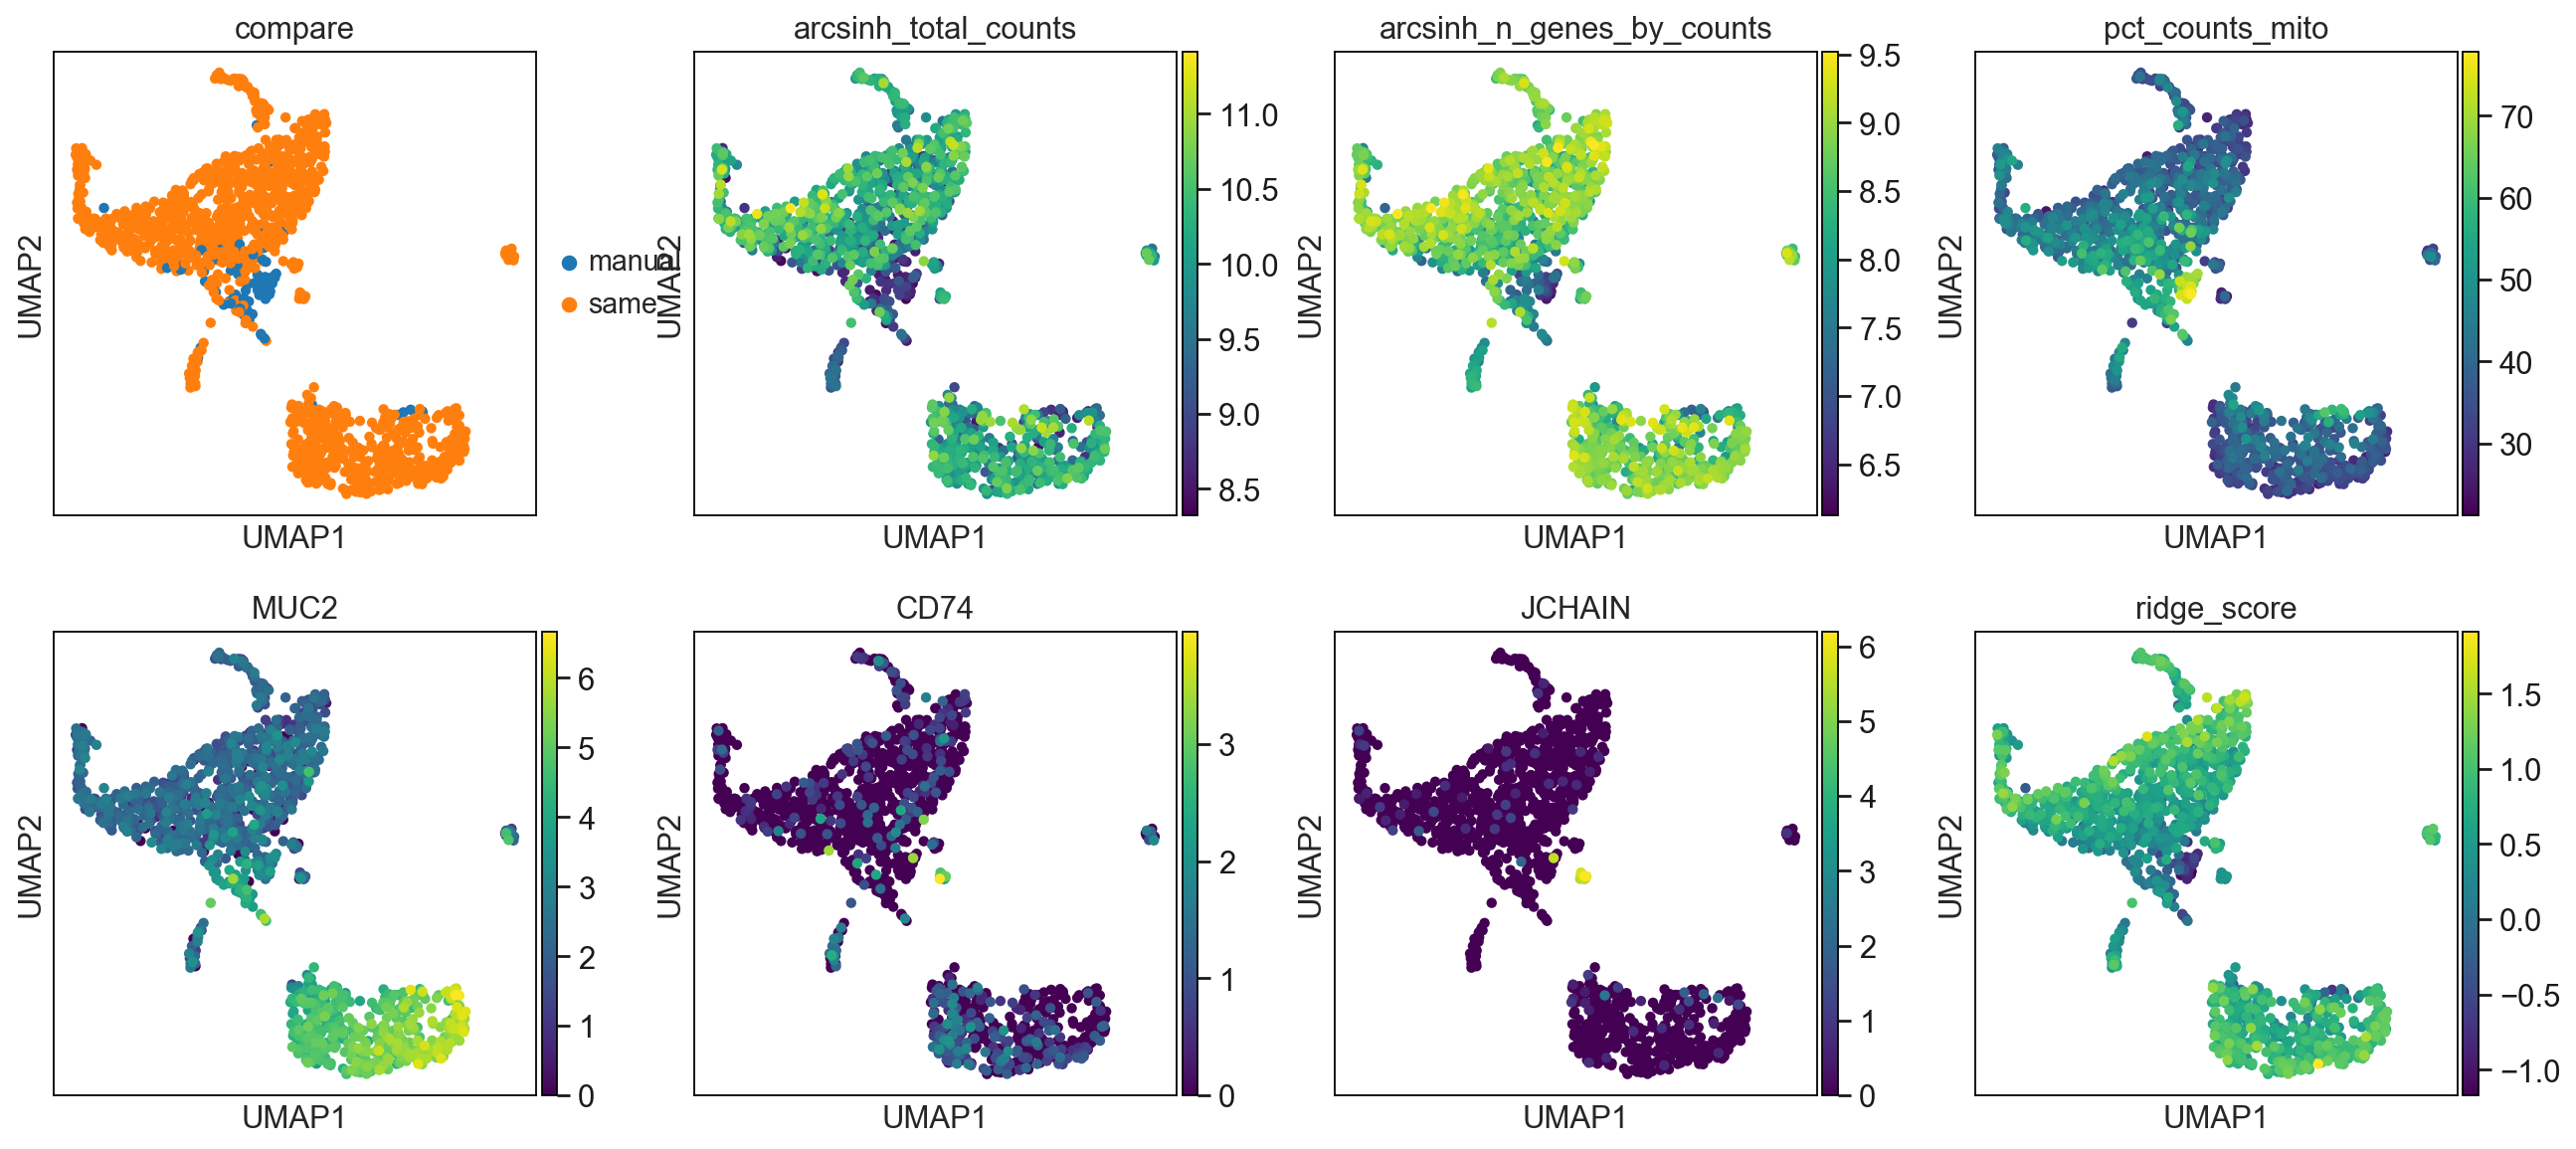

In [63]:
# show UMAP of Ken's data and look at difference from TwoStep
sc.pl.umap(s1_ken, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','MUC2','CD74','JCHAIN','ridge_score'])

---
#### Now do the same on Threshold results

In [64]:
s1_thresh = s1[s1.obs['thresh_filter']==1,:].copy()

In [65]:
# preprocess
s1_thresh.X = s1_thresh.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_thresh, min_cells=1)
recipe_fcc(s1_thresh, X_final='arcsinh_norm', mito_names='^MT-')
s1_thresh.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_thresh.obs['n_genes_by_counts'])

... storing 'compare' as categorical


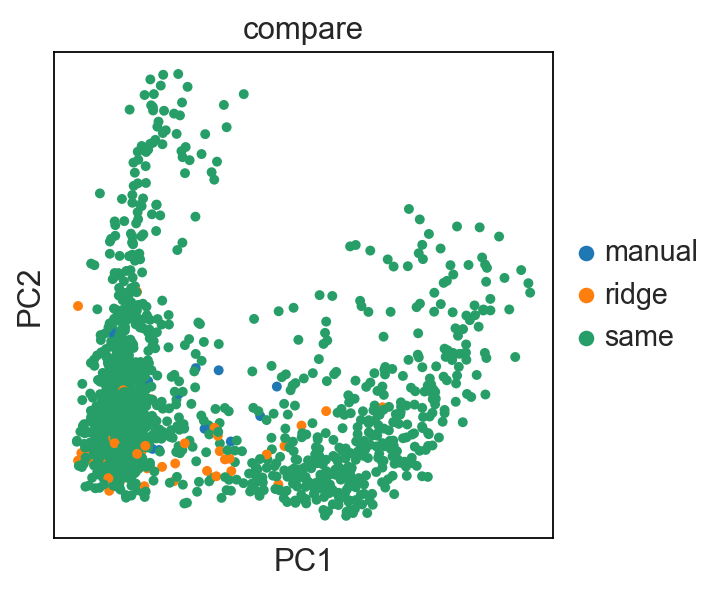

CPU times: user 1.45 s, sys: 295 ms, total: 1.75 s
Wall time: 303 ms


In [66]:
%%time
sc.tl.pca(s1_thresh, n_comps=10)
sc.pl.pca(s1_thresh, color=['compare'])

In [67]:
sc.pp.neighbors(s1_thresh, n_neighbors=int(np.sqrt(s1_thresh.n_obs)))
sc.tl.umap(s1_thresh)

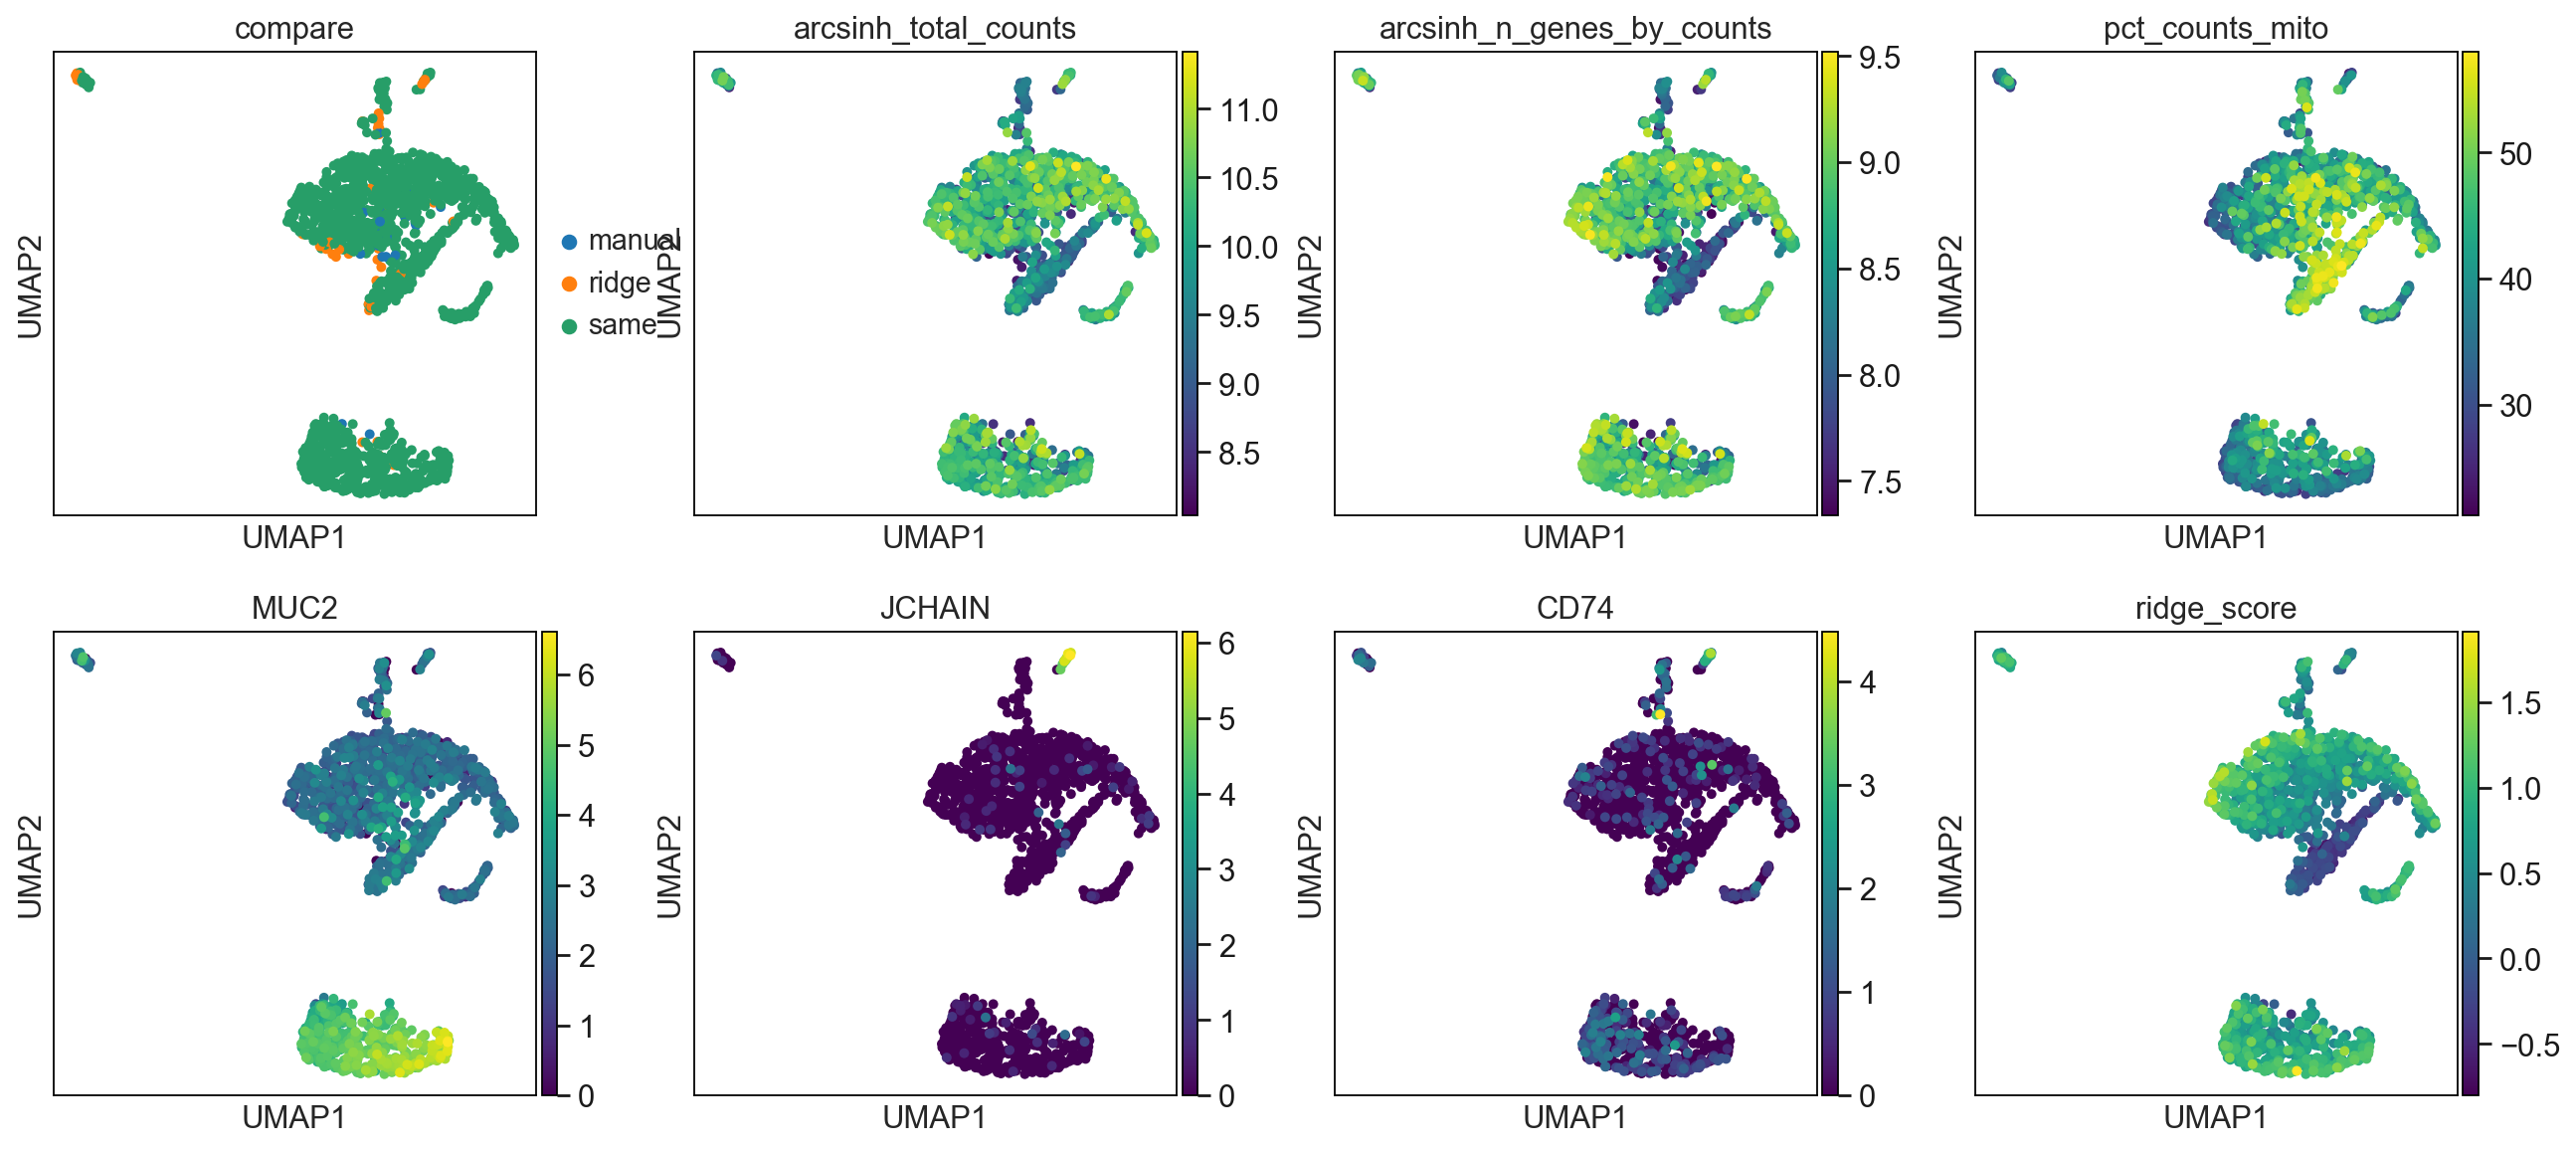

In [68]:
sc.pl.umap(s1_thresh, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','MUC2','JCHAIN','CD74','ridge_score'])

---
#### Now do the same on RidgeClassifier results

In [71]:
# preprocess
s1_ridge.X = s1_ridge.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ridge, min_cells=1)
recipe_fcc(s1_ridge, X_final='arcsinh_norm', mito_names='^MT-')
s1_ridge.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ridge.obs['n_genes_by_counts'])

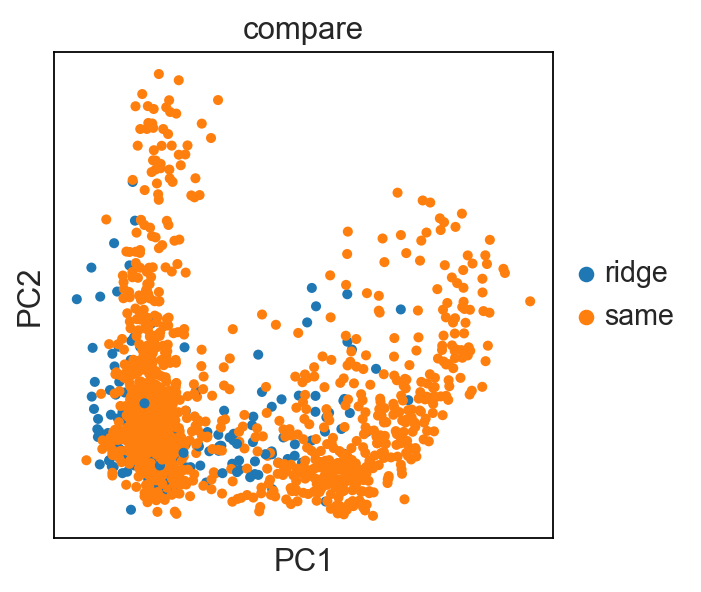

CPU times: user 1.42 s, sys: 285 ms, total: 1.71 s
Wall time: 282 ms


In [72]:
%%time
sc.tl.pca(s1_ridge, n_comps=10)
sc.pl.pca(s1_ridge, color=['compare'])

In [73]:
sc.pp.neighbors(s1_ridge, n_neighbors=int(np.sqrt(s1_ridge.n_obs)))
sc.tl.umap(s1_ridge)

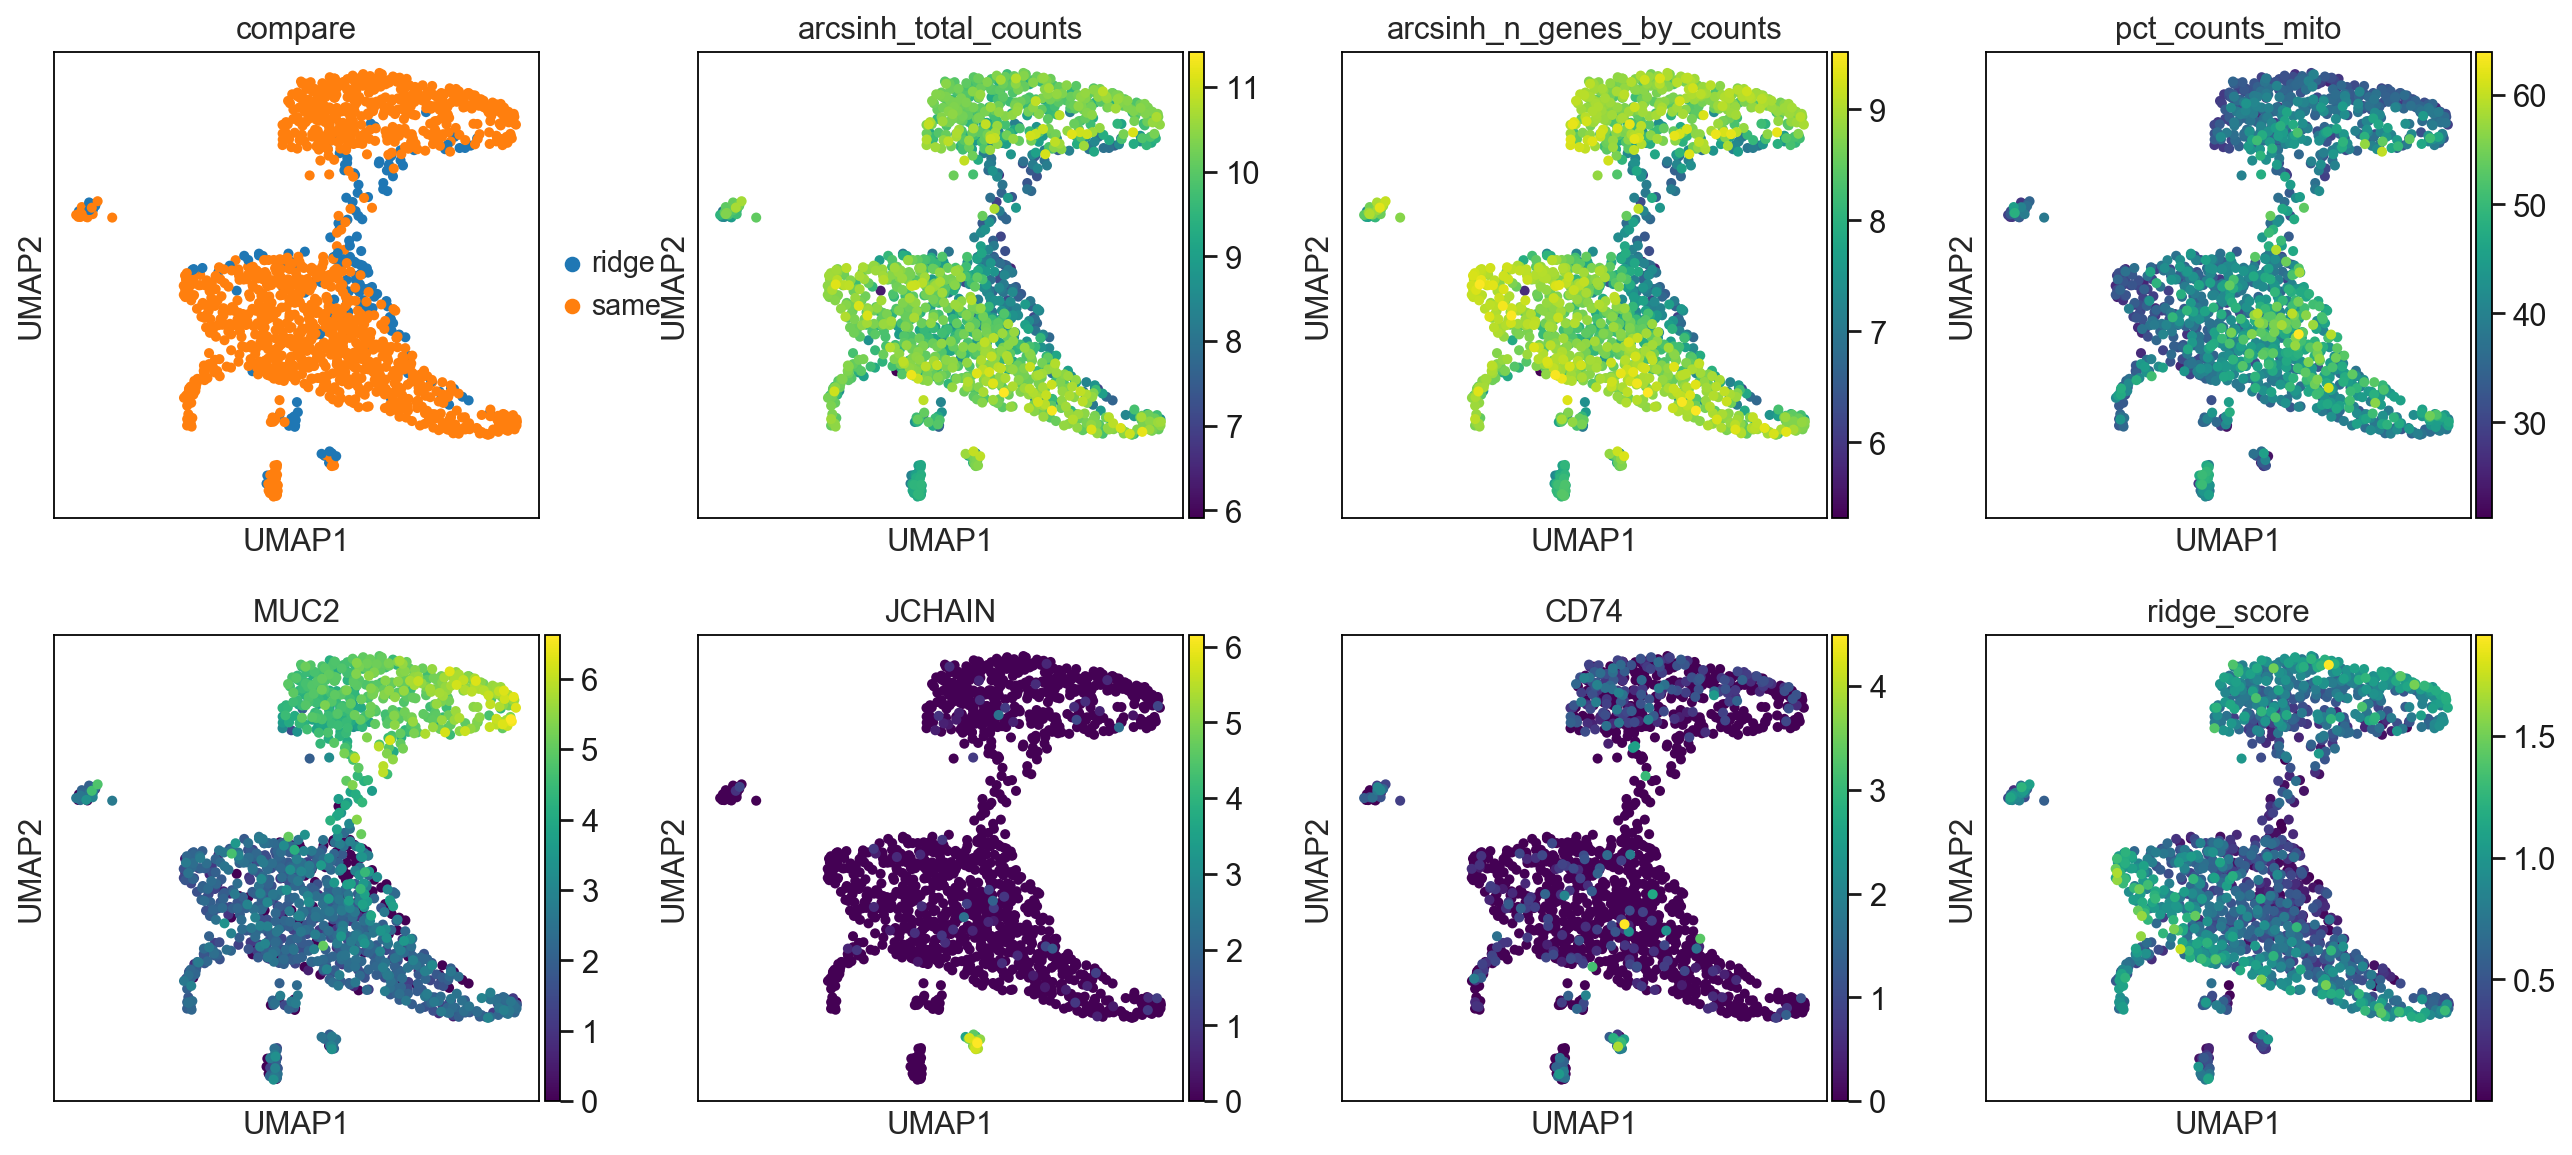

In [74]:
sc.pl.umap(s1_ridge, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','MUC2','JCHAIN','CD74','ridge_score'])

In [75]:
s1_ken.shape

(1369, 25484)

In [76]:
s1_thresh.shape

(1507, 25672)

In [77]:
s1_ridge.shape

(1462, 25615)